### Blob Detection using Laplacians of Gaussian and scale-space extrema detection

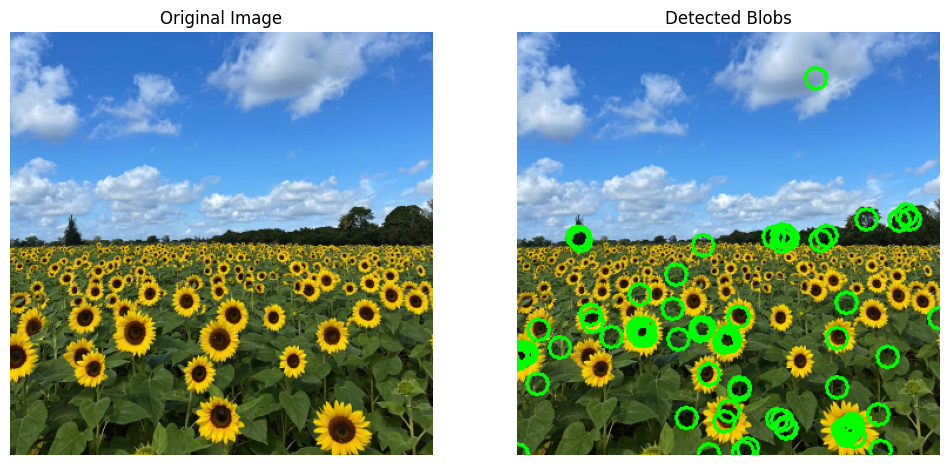

Largest blob radius: 9.113820735293281
Range of sigma values used: [ 1.          6.44444444 11.88888889 17.33333333 22.77777778 28.22222222
 33.66666667 39.11111111 44.55555556 50.        ]


In [16]:
import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt

# Load the image
im = cv.imread('Images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
im_rgb = cv.cvtColor(im, cv.COLOR_BGR2RGB)
im_gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

# Generate blurred images to detect blobs at different scales
sigma_values = np.linspace(1, 50, 10)
blurred_images = [cv.GaussianBlur(im_gray, (0, 0), sigma) for sigma in sigma_values]

# Compute the Laplacian of Gaussian
blobs_log = [cv.Laplacian(img, cv.CV_64F) for img in blurred_images]

threshold = 3.00

# Find local extrema across the scale
def blob_detector(images, sigma_values, threshold):
    blobs = []
    blob_radii = []

    for i in range(1, len(images) - 1):
        cur, prev, nxt = images[i], images[i - 1], images[i + 1]
        extrema = np.logical_and(np.logical_and(cur > prev, cur > nxt), cur > threshold)
        y_x = np.argwhere(extrema)  # centers of the blobs
        if y_x.size > 0:
            blobs.append(y_x)
            blob_radii.append(sigma_values[i] * np.sqrt(2))  # Append radii for each detected blob

    return blobs, blob_radii

blobs, blob_radii = blob_detector(blobs_log, sigma_values, threshold)

# Find the largest blob
largest_blob_index = np.argmax([len(blob) for blob in blobs])
largest_blob = blobs[largest_blob_index]
largest_blob_radius = blob_radii[largest_blob_index]

output_image = im.copy()
output_image = cv.cvtColor(output_image, cv.COLOR_BGR2RGB)

# Draw circles around detected blobs
for center in largest_blob:
    cv.circle(output_image, (int(center[1]), int(center[0])), int(largest_blob_radius), (0, 255, 0), 2)

# Display the image with detected blobs
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(im_rgb, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(output_image, cmap='gray', vmin=0, vmax=255)
ax[1].set_title('Detected Blobs')
ax[1].axis('off')
plt.show()

# Report the parameters of the largest circles
print(f"Largest blob radius: {largest_blob_radius}")
print(f"Range of sigma values used: {sigma_values}")

### Fitting lines

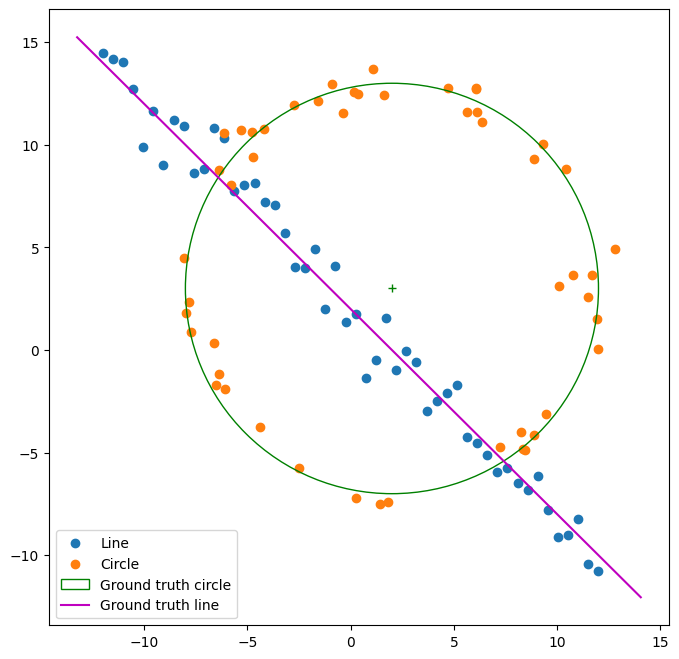

In [60]:
#Listing 1 to generate noisy points
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
# np . random . seed ( 0 )
N = 100
half_n = N//2

r = 10
x0_gt,y0_gt = 2,3 # Center
s = r/16
t = np.random.uniform(0,2*np.pi,half_n)
n = s*np.random.randn(half_n)
x,y = x0_gt + (r + n)*np.cos(t),y0_gt + (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n,1),y.reshape(half_n,1)))
s = 1.
m,b = -1, 2
x = np.linspace (-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack ((x.reshape(half_n, 1), y.reshape(half_n,1)))
X = np.vstack((X_circ, X_line)) # All points
fig , ax = plt.subplots(1 ,1 , figsize=(8 ,8))
ax.scatter(X_line[:, 0], X_line[:, 1], label= 'Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label= 'Circle')
circle_gt = plt.Circle((x0_gt , y0_gt), r, color= 'g' , fill = False , label= 'Ground truth circle' )
ax.add_patch (circle_gt)
ax.plot ((x0_gt ) , (y0_gt) , '+' , color= 'g')
x_min , x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m*x_+b
plt . plot(x_, y_ ,color= 'm' , label= 'Ground truth line' )
plt . legend ( )

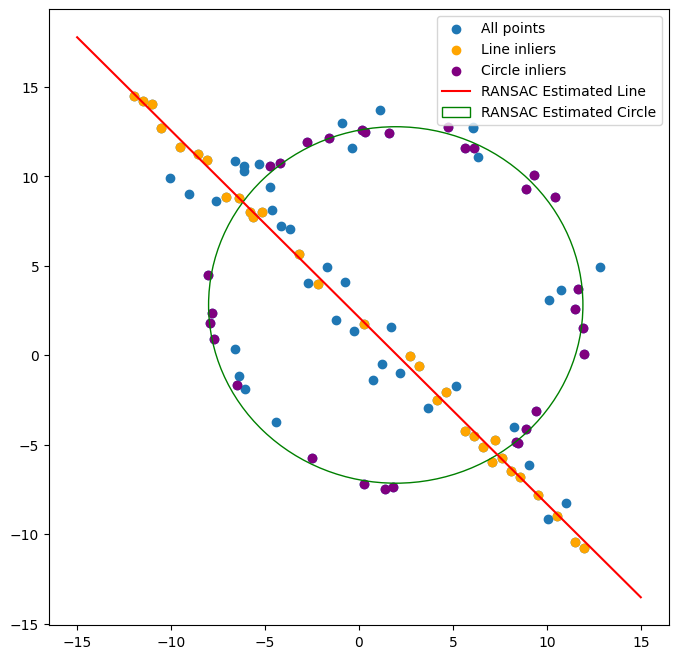

In [64]:
def estimate_circle_ransac(X, threshold, iterations):
    best_inliers = []
    best_circle = None

    for _ in range(iterations):
        # Randomly sample three points to define a circle
        sample_indices = np.random.choice(X.shape[0], 3, replace=False)
        pts = X[sample_indices]

        # Estimate circle parameters using the three points
        A = 2 * (pts[1] - pts[0])
        B = 2 * (pts[2] - pts[0])
        C = np.array([np.sum(pts[1]**2 - pts[0]**2), np.sum(pts[2]**2 - pts[0]**2)])

        try:
            center = np.linalg.solve(np.array([A, B]), C)
            radius = np.linalg.norm(center - pts[0])
        except np.linalg.LinAlgError:
            continue

        # Compute distances to the circle and count inliers
        distances = np.abs(np.sqrt((X[:, 0] - center[0])**2 + (X[:, 1] - center[1])**2) - radius)
        inliers = X[distances < threshold]

        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_circle = (center, radius)

    return best_circle[0], best_circle[1], np.array(best_inliers)

# Main execution
params_line, line_inliers = estimate_line_ransac(X, threshold=0.5, iterations=1000)
center_circle, radius_circle, circle_inliers = estimate_circle_ransac(X[~np.isin(X, line_inliers).all(axis=1)], threshold=0.5, iterations=1000)

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='All points')
ax.scatter(line_inliers[:, 0], line_inliers[:, 1], label='Line inliers', color='orange')
ax.scatter(circle_inliers[:, 0], circle_inliers[:, 1], label='Circle inliers', color='purple')

# Plot line
a, b, d = params_line
x_line = np.linspace(-15, 15, 100)
y_line = -(a * x_line + d) / b
ax.plot(x_line, y_line, color='red', label='RANSAC Estimated Line')

# Plot circle
circle = plt.Circle(center_circle, radius_circle, color='green', fill=False, label='RANSAC Estimated Circle')
ax.add_patch(circle)

plt.legend()
plt.show()


### Superimpose images

The code for this task is implemented seprately and the following results were obtained



### Image Stiching

C:\Users\ANUSHKA\AppData\Local\Temp\ipykernel_20008\2258360405.py:63: RuntimeWarning: divide by zero encountered in divide
  projected_points /= projected_points[2]  # Normalize
C:\Users\ANUSHKA\AppData\Local\Temp\ipykernel_20008\2258360405.py:63: RuntimeWarning: invalid value encountered in divide
  projected_points /= projected_points[2]  # Normalize


Computed Homography (RANSAC):
 [[-6.51333982e-01 -4.18178903e-01  4.32431442e+02]
 [-5.29189899e-01 -3.38564670e-01  3.50561243e+02]
 [-1.51007945e-03 -9.64581147e-04  1.00000000e+00]]
Given Homography:
 [[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]


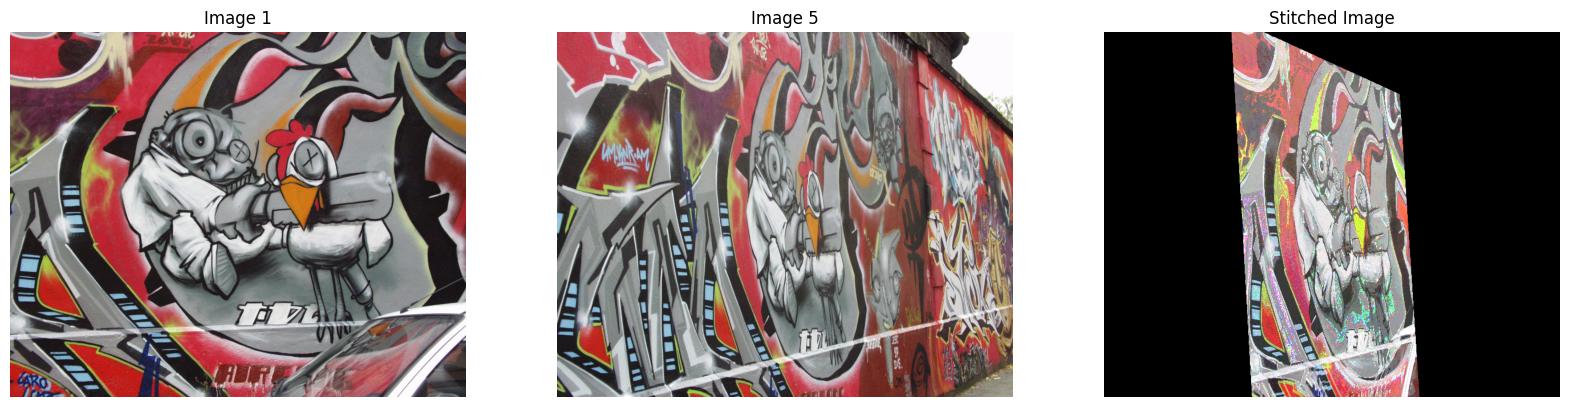

In [24]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the images
img1 = cv.imread('Images/graf/img1.ppm')
img5 = cv.imread('Images/graf/img5.ppm')

# Convert images to grayscale
gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
gray5 = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv.SIFT_create()

# Detect SIFT features and compute descriptors
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints5, descriptors5 = sift.detectAndCompute(gray5, None)

# Match descriptors using FLANN matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1, descriptors5, k=2)

# Store good matches using Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Draw matches
img_matches = cv.drawMatches(img1, keypoints1, img5, keypoints5, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Extract location of good matches
points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
points5 = np.zeros((len(good_matches), 2), dtype=np.float32)

for i, match in enumerate(good_matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points5[i, :] = keypoints5[match.trainIdx].pt

# RANSAC Implementation to compute Homography
def ransac_homography(points1, points5, threshold=5.0, iterations=1000):
    best_H = None
    best_inliers_count = 0
    num_points = points1.shape[0]
    
    for _ in range(iterations):
        # Randomly select 4 points
        indices = np.random.choice(num_points, 4, replace=False)
        sample_points1 = points1[indices]
        sample_points5 = points5[indices]

        # Calculate homography from sample points
        H, _ = cv.findHomography(sample_points1, sample_points5)

        if H is not None:
            # Project points1 to points5 using the homography
            points1_homogeneous = np.hstack((points1, np.ones((num_points, 1)))).T
            projected_points = H @ points1_homogeneous
            projected_points /= projected_points[2]  # Normalize

            # Calculate the distance to the actual points
            distances = np.sqrt(np.sum((points5 - projected_points[:2].T) ** 2, axis=1))

            # Count inliers
            inliers = distances < threshold
            inliers_count = np.sum(inliers)

            if inliers_count > best_inliers_count:
                best_inliers_count = inliers_count
                best_H = H

    return best_H

# Compute homography using RANSAC
H_ransac = ransac_homography(points1, points5)

# Compare with the given homography
H_given = np.array([[6.2544644e-01, 5.7759174e-02, 2.2201217e+02],
                    [2.2240536e-01, 1.1652147e+00, -2.5605611e+01],
                    [4.9212545e-04, -3.6542424e-05, 1.0000000e+00]])

print("Computed Homography (RANSAC):\n", H_ransac)
print("Given Homography:\n", H_given)

# Use the homography matrix to warp img1 to img5's perspective
height, width, channels = img5.shape
img1_warped = cv.warpPerspective(img1, H_given, (width, height))

# Create a mask of img1_warped
mask = np.zeros((height, width), dtype=np.uint8)
mask[img1_warped[:, :, 0] > 0] = 255

# Combine the two images
stitched_image = cv.bitwise_or(img5, img1_warped, mask=mask)

# Making the final image fitting to the border
stitched_image = cv.resize(stitched_image, (img5.shape[1], img5.shape[0]))

# Display the results
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
ax[0].set_title('Image 1')
ax[0].axis('off')
ax[1].imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
ax[1].set_title('Image 5')
ax[1].axis('off')
ax[2].imshow(cv.cvtColor(stitched_image, cv.COLOR_BGR2RGB))
ax[2].set_title('Stitched Image')
ax[2].axis('off')
plt.show()
